<a href="https://colab.research.google.com/github/yskmt2018/quantum/blob/master/clique_cover_problem_sqa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clique Cover Problem with Simulated Quantum Annealing

* This notebook was created and tested on Google Colaboratory. (2020/09)

## Reference

> https://openjij.github.io/OpenJijTutorial/build/html/ja/3-PyQUBO_2_OpenJij.html

In [1]:
!python -V
!pip install --quiet pyqubo openjij

Python 3.6.9


In [2]:
%matplotlib inline
import random
import pyqubo
import networkx as nx
import matplotlib.pyplot as plt
from openjij import SQASampler

## Problem Settings

 グラフ$G=(V,E)$を$n$個のクリークで被覆できるかという問題。

In [3]:
def plot_graph(N, E, colors=None):
  G = nx.Graph()
  G.add_nodes_from([n for n in range(N)])
  for (i, j) in E:
    G.add_edge(i, j)
  plt.figure(figsize=(10,10))
  pos = nx.circular_layout(G)
  colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
  if colors:
    nx.draw_networkx(G, pos, node_color=[colorlist[colors[node]] for node in G.nodes], node_size=400, font_weight='bold', font_color='w')
  else:
    nx.draw_networkx(G, pos, node_color=[colorlist[0] for _ in G.nodes], node_size=400, font_weight='bold', font_color='w')
  plt.axis('off')
  plt.show()

In [4]:
def random_edge(edge_number):
  E = set()
  while len(E) < edge_number:
    f = random.randrange(0, V)
    t = random.randrange(0, V)
    if f != t:
      E.add((f, t))
  
  return E

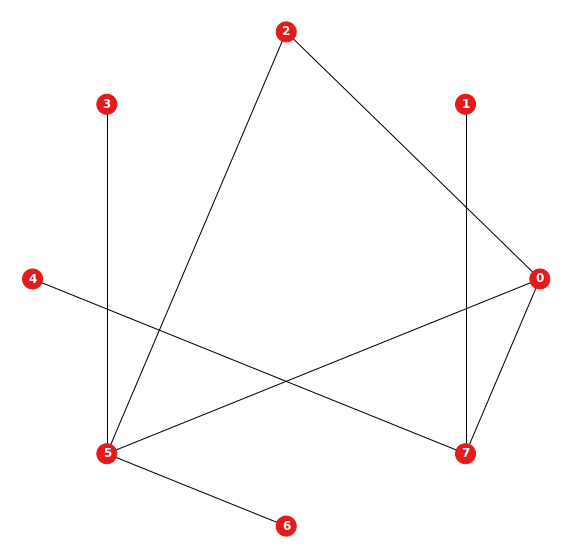

In [5]:
# Vertex Number
V = 8
# Color Number
K = 4
# Edge
E = random_edge(9)

plot_graph(V, E)

## Formulation

* CCP の目的関数及び制約条件を定式化し、QUBO（Quadratic Unconstrained Binary Optimization）式を構築する。

* QUBO 式の構築には、OSS ライブラリ PyQUBO（[GitHub](https://github.com/recruit-communications/pyqubo), [Documentation](https://pyqubo.readthedocs.io/en/latest/)）を用いる。

### QUBO1: Objective Function

* 目的関数：分割した部分グラフがどれだけクリーク（完全グラフ）に近いか

$$
\sum^K_{k=1} \left[\frac{1}{2} \left(-1 + \sum_{v \in V} x_{v,k} \right)\sum_{v \in V} x_{v, k} - \sum_{(u, v) \in E} x_{u,k} x_{v, k} \right]
$$

In [6]:
def build_objective(x):
  H = sum((-1 + sum(x[v, k] for v in range (V))) / 2 * 
          (sum(x[v, k] for v in range (V))) - sum(x[u, k] * x[v, k] for (u, v) in E) for k in range (1, K))
  return H

### QUBO2: Onecolor rule

* 制約条件：1つの頂点はただ1色に対応する。

$$
w\sum_{v \in V}\left(1 - \sum_{k = 1}^{K} x_{v,k}\right)^2
$$

In [7]:
def build_onecolor_rule(x):
  H = pyqubo.Constraint(sum((1 - sum(x[v, k] for k in range(1, K))) ** 2 for v in range(V)), 'w')
  return H

### Hamiltonian

* 目的関数及び制約条件からハミルトニアン H を以下のように定義する。

$$
H = \sum^K_{k=1} \left[\frac{1}{2} \left(-1 + \sum_{v \in V} x_{v,k} \right)\sum_{v \in V} x_{v, k} - \sum_{(u, v) \in E} x_{u,k} x_{v, k} \right]
+w\sum_{v \in V}\left(1 - \sum_{k = 1}^{K} x_{v,k}\right)^2
$$

In [8]:
# Clique Cover
x = pyqubo.Array.create('x', shape=(V, K), vartype='BINARY')

In [9]:
H = build_objective(x) + \
    pyqubo.Placeholder('w') * build_onecolor_rule(x)

In [10]:
feed_dict = {'w': 1}

In [11]:
model = H.compile()
qubo, constant = model.to_qubo(feed_dict=feed_dict)

## Execute Quantum Annealing

* Sampler と呼ばれるモジュールを生成し、構築した QUBO 式を渡すことで、量子アニーリングを実行する。

* 結果は、Response オブジェクトとして返却される。

### OpenJij

* OpenJij（[GitHub](https://github.com/OpenJij/OpenJij), [Documentation](https://openjij.github.io/OpenJij_Documentation/build/html/), [Tutorial](https://openjij.github.io/OpenJijTutorial/build/html/ja/index.html)）

* OSS として、量子アニーリングをシミュレートする SQA（Simulated Quantum Annealing）の Python 用 API を提供している。

In [12]:
sampler = SQASampler(num_reads=10)

In [13]:
%%time
response = sampler.sample_qubo(qubo)

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 203 ms


### Take Solutions

* Response オブジェクトに格納されている量子アニーリングの結果（解）を取り出す。

In [14]:
def extract_samples(response):
  solutions = []
  energies = []
  
  for record in response.record:
    sol, num_occ = record[0], record[2]
    solution, broken, energy = model.decode_solution(dict(zip(response.variables, sol)), vartype='BINARY', feed_dict=feed_dict)
    if len(broken) == 0:
      solutions += [solution] * num_occ
      energies += [energy] * num_occ
  
  return solutions, energies

In [15]:
solutions, energies = extract_samples(response)
best_solution = solutions[energies.index(min(energies))]

### Print Graph Coloring

* 各頂点の色を取得し、分割後のグラフを表示する。

* 先に設定した制約条件が満たされていることを確認してください。

> 1つの頂点はただ1色に対応する。

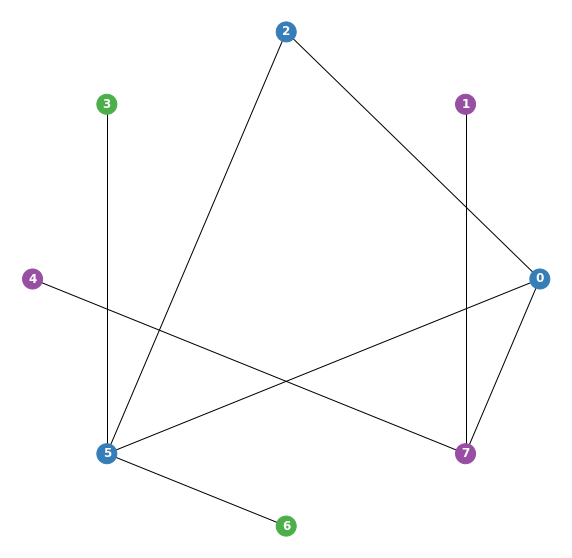

In [16]:
colors = [0 for v in range(V)]
for v in range(V):
  for k in range(1, K):
    if best_solution['x'][v][k] == 1:
      colors[v] = k
      break

plot_graph(V, E, colors)